In [2]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [3]:
df = pd.read_csv('insurance.csv')

In [4]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


Attributes 

age: age of primary beneficiary

sex: insurance contractor gender, female, male

bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

children: Number of children covered by health insurance / Number of dependents

smoker: Smoking or not

region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

charges: Individual medical costs billed by health insurance

# DATA CLEANING

### Duplicates

In [5]:
df.duplicated().sum()

1

In [6]:
df.drop_duplicates(inplace = True)
df.shape

(1337, 7)

### Leading and Trailing Spaces

In [7]:
for col in df.select_dtypes(include = ['object']):
  df[col] = df[col].str.strip()

### Null Values

In [8]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### Outlier Detection and Resolution

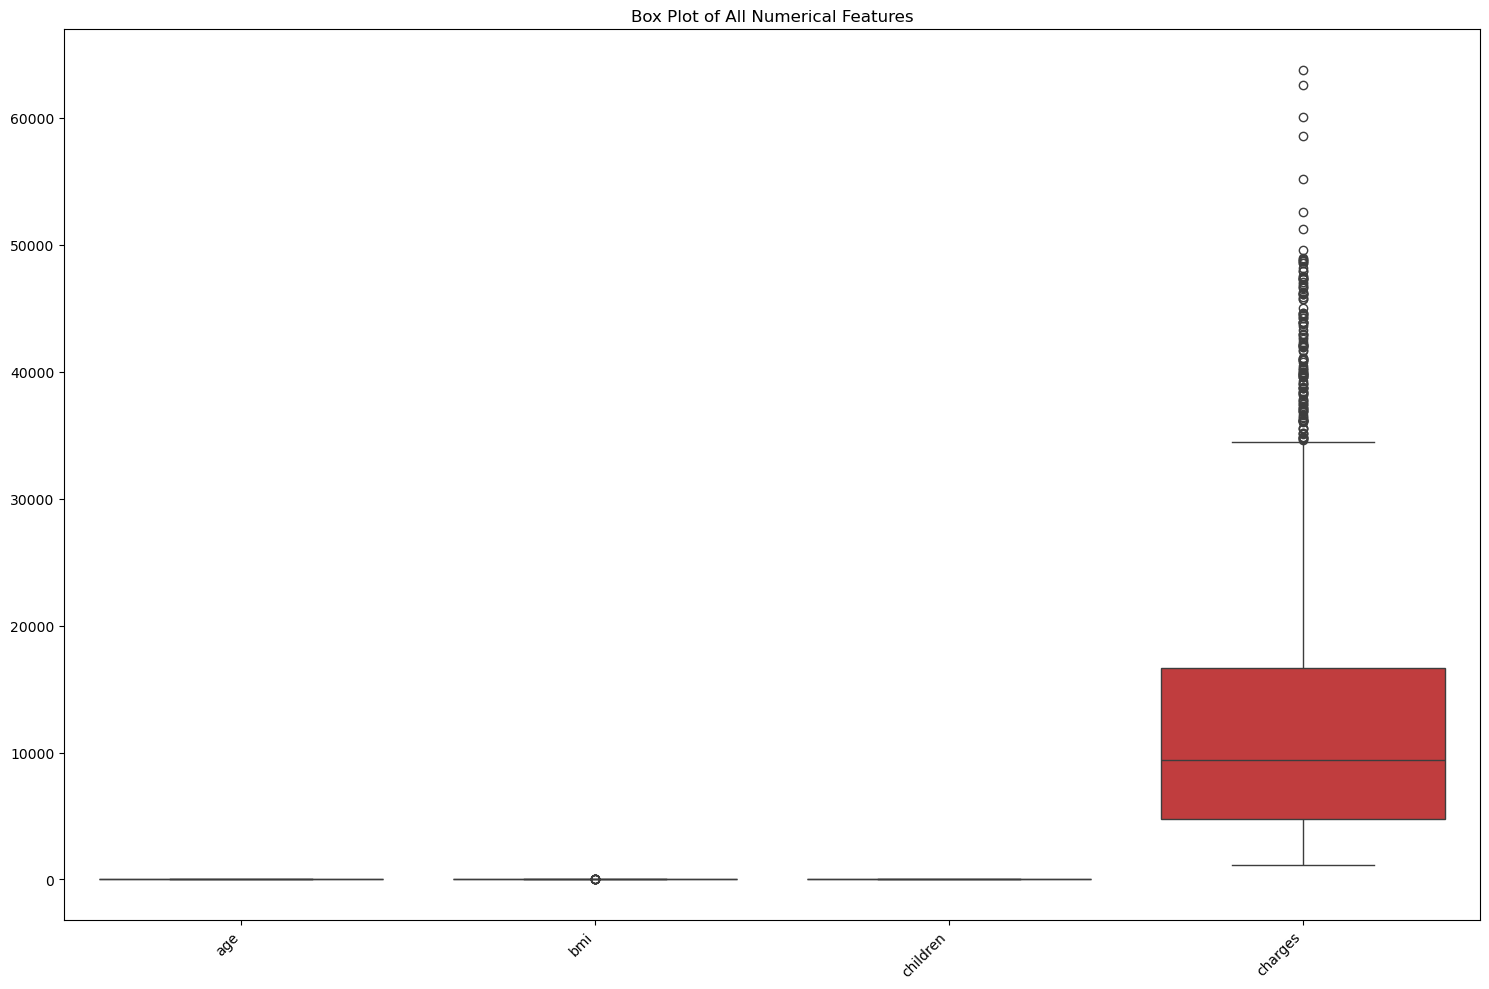

In [9]:
numerical_features = ['age', 'bmi', 'children', 'charges']

# Create the box plot
plt.figure(figsize=(15, 10))  # Adjust figure size as needed
sns.boxplot(data = df[numerical_features])
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.title('Box Plot of All Numerical Features')
plt.tight_layout()
plt.show()

In [10]:
percentile_75 = df['charges'].quantile(0.75)
filtered_df = df[df['charges'] > percentile_75]
filtered_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
3,33,male,22.705,0,no,northwest,21984.47061
9,60,female,25.840,0,no,northwest,28923.13692
11,62,female,26.290,0,yes,southeast,27808.72510
14,27,male,42.130,0,yes,southeast,39611.75770
...,...,...,...,...,...,...,...
1318,35,male,39.710,4,no,northeast,19496.71917
1321,62,male,26.695,0,yes,northeast,28101.33305
1323,42,female,40.370,2,yes,southeast,43896.37630
1328,23,female,24.225,2,no,northeast,22395.74424


In [11]:
df.describe(include = 'all')

,age,sex,bmi,children,smoker,region,charges
count,1337.000000,1337,1337.000000,1337.000000,1337,1337,1337.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,675,NaN,NaN,1063,364,NaN
mean,39.222139,NaN,30.663452,1.095737,NaN,NaN,13279.121487
std,14.044333,NaN,6.100468,1.205571,NaN,NaN,12110.359656
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.290000,0.000000,NaN,NaN,4746.344000
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9386.161300
75%,51.000000,NaN,34.700000,2.000000,NaN,NaN,16657.717450


# EXPLORATORY DATA ANALYSIS

### Check Feature Distribution
Check if the data set is balanced

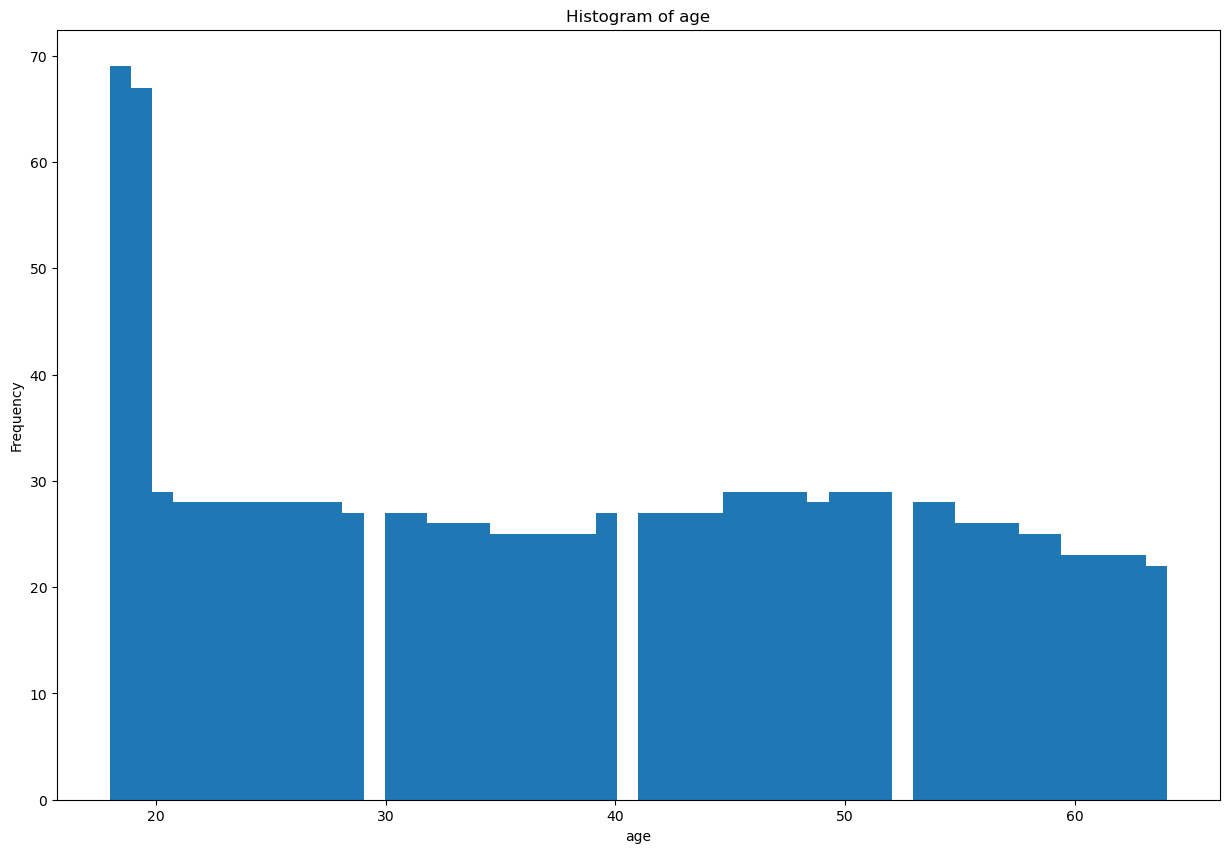

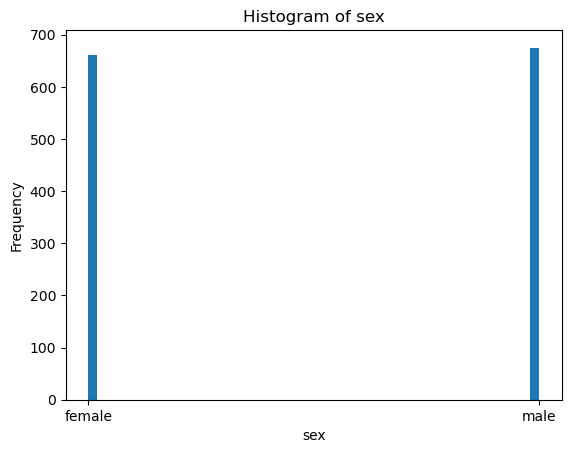

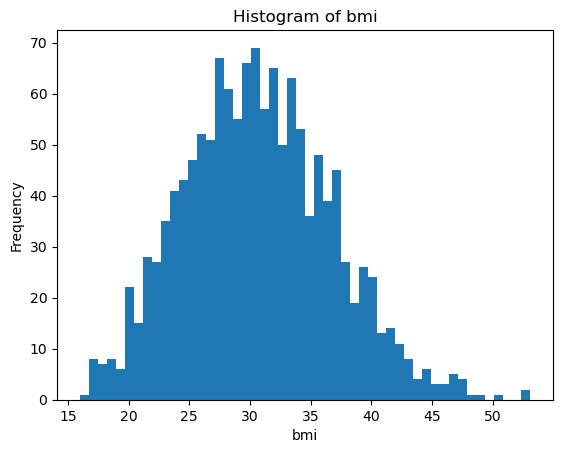

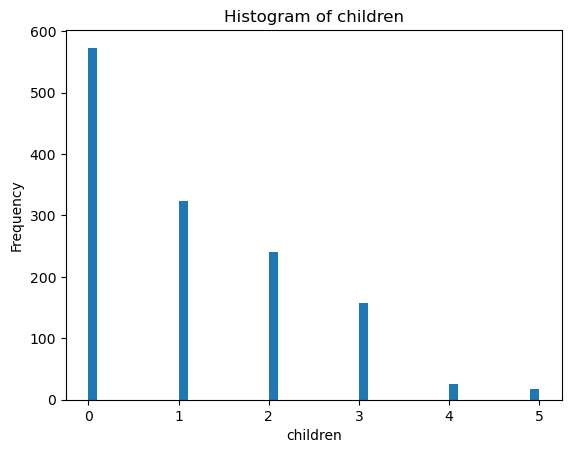

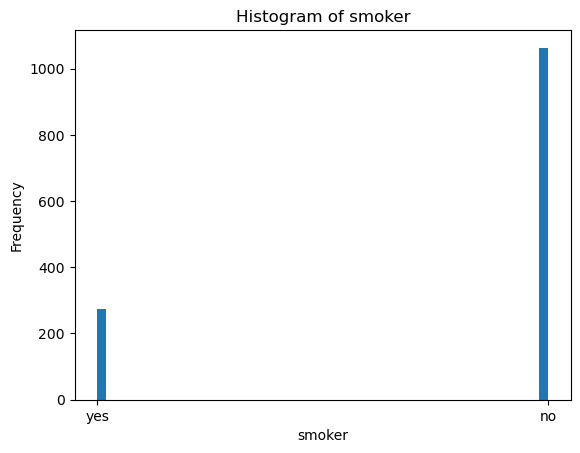

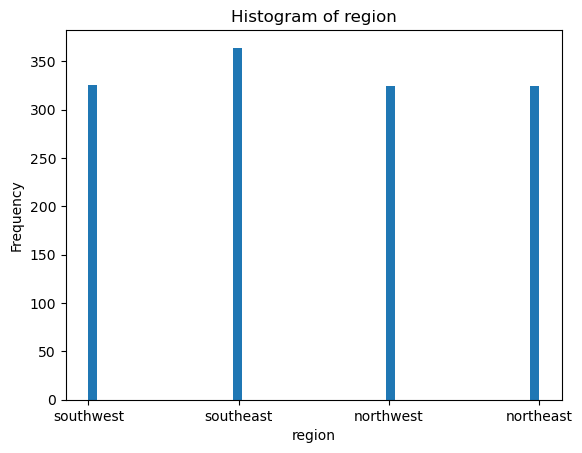

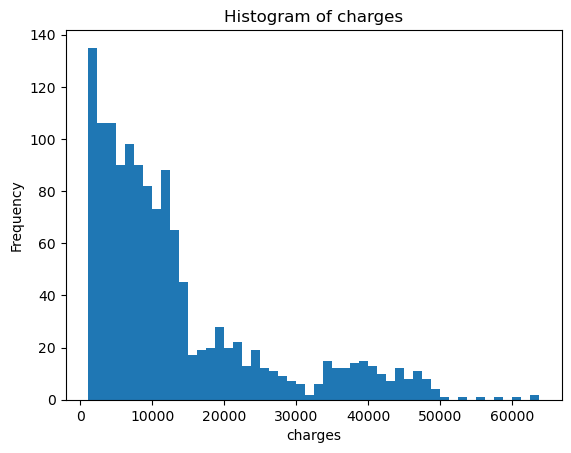

In [12]:
# create histograms for all features of df
plt.figure(figsize=(15, 10))
for column in df.columns:
    plt.hist(df[column], bins = 50) # Adjust the number of bins as needed
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


From the histograms above, we can see that:

1. Sex, BMI, Region Features are well balanced or normally-distributed
2. Age has more young people (in their 20s)
3. More people have no children
4. Smoker is unbalanced with more non-smokers

### Correlation

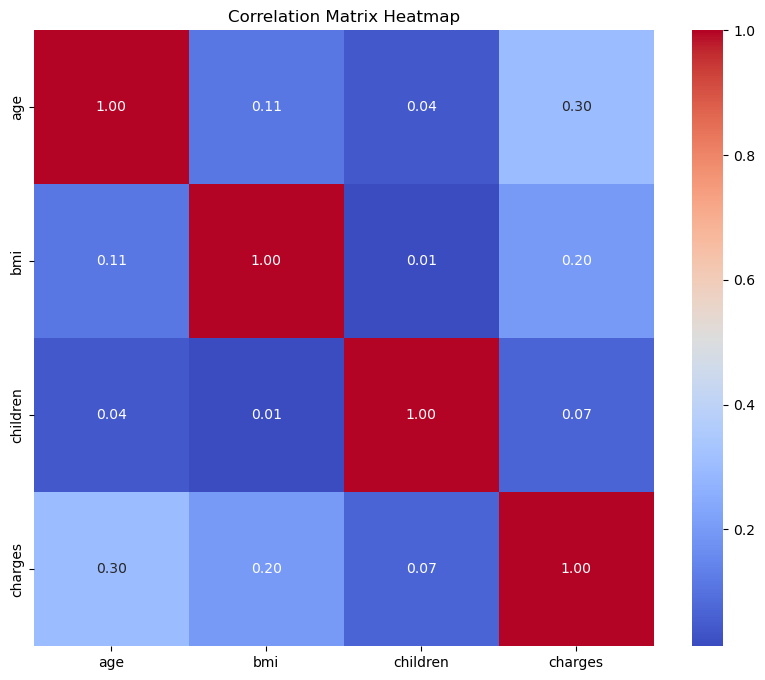

In [13]:
# Create correlation ship heat map for numerical features
# Calculate the correlation matrix
correlation_matrix = df.corr(numeric_only = True)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

The numerical features in the data set generally seem to have low correlation with each other. The highest correlation was between age and charges at 0.30. This was followed by BMI and charges at 0.20. Age and BMI has 0.11 correlation.

### One-Hot Encoding

In [14]:
# Define categorical features
categorical_features = ['sex', 'smoker', 'region']
# one-hot encode categorical features
df = pd.get_dummies(df, columns = ['sex', 'smoker', 'region'])

# DATA SPLIT

In [15]:
X = df.drop('charges', axis=1)
y = df['charges']  # Target variable

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)  # Adjust test_size and random_state as needed

# DATA PREPROCESSING

### Standardization

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# MODEL TRAINING

### Linear Regression

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

### Decision Tree

In [19]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

DecisionTreeRegressor()

### Random Forest

In [20]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

# PREDICTIONS

In [21]:
y_pred_lr = lr.predict(X_test)
y_pred_dt = dt.predict(X_test)
y_pred_rf = rf.predict(X_test)

# EVALUATION

In [22]:
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Create a comparison table
model_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest'],
    'Mean Absolute Error': [mae_lr, mae_dt, mae_rf],
    'Mean Squared Error': [mse_lr, mse_dt, mse_rf],
    'R-squared': [r2_lr, r2_dt, r2_rf]
})

model_comparison

,Model,Mean Absolute Error,Mean Squared Error,R-squared
0,Linear Regression,4205.489652,3.589593e+07,0.804654
1,Decision Tree,2876.703224,3.943967e+07,0.785369
2,Random Forest,2644.877339,2.231523e+07,0.878561


# RANDOM FOREST MODEL OPTIMIZATION

In [23]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator = RandomForestRegressor(random_state = 42),
                           param_grid = param_grid,
                           scoring = 'neg_mean_squared_error',
                           cv = 5,
                           verbose = 2)

In [24]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END ma

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=2)

In [25]:
# Identify the best parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: -21499958.381350126


In [26]:
# Use the best parameters to create the model
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, min_samples_leaf=4, n_estimators=200,
                      random_state=42)

In [27]:
# Predict
y_pred_rf_best = best_rf_model.predict(X_test)

In [28]:
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mae_rf_best = mean_absolute_error(y_test, y_pred_rf_best)
mse_rf_best = mean_squared_error(y_test, y_pred_rf_best)
r2_rf_best = r2_score(y_test, y_pred_rf_best)

# Create a comparison table
model_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest', 'Random Forest Best'],
    'Mean Absolute Error': [mae_lr, mae_dt, mae_rf, mae_rf_best],
    'Mean Squared Error': [mse_lr, mse_dt, mse_rf, mse_rf_best],
    'R-squared': [r2_lr, r2_dt, r2_rf, r2_rf_best]
})

model_comparison

,Model,Mean Absolute Error,Mean Squared Error,R-squared
0,Linear Regression,4205.489652,3.589593e+07,0.804654
1,Decision Tree,2876.703224,3.943967e+07,0.785369
2,Random Forest,2644.877339,2.231523e+07,0.878561
3,Random Forest Best,2364.741263,1.765861e+07,0.903902
